# VQGAN-JAX: How to Use

This notebook shows how to use [our finetuned version of VQGAN-f16-16384](https://huggingface.co/flax-community/vqgan_f16_16384) for simple encoding and decoding.

It is essentially a copy of Suraj Patil's notebook: https://colab.research.google.com/drive/1mdXXsMbV6K_LTvCh3IImRsFIWcKU5m1w?usp=sharing, which uses a similar model pre-trained on ImageNet. It requires his modeling code, referenced in the cell below.

In [ ]:
!pip install git+https://github.com/patil-suraj/vqgan-jax.git

In [ ]:
import io

import requests
from PIL import Image
import numpy as np

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

from vqgan_jax.modeling_flax_vqgan import VQModel

In [ ]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content))

def preprocess_vqgan(x):
    x = 2.*x - 1.
    return x

def custom_to_pil(x):
    x = np.clip(x, -1., 1.)
    x = (x + 1.)/2.
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def preprocess(img, target_image_size=256,):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=InterpolationMode.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()

In [ ]:
model = VQModel.from_pretrained("flax-community/vqgan_f16_16384")

In [ ]:
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'
size=384
image = download_image(url)
image = preprocess(image, size)

In [ ]:
image.shape

(1, 384, 384, 3)

The image was downscaled and cropped to a size of `384 × 384`. Since the reduction factor is 16, we expect the model to produce `384/16 × 384/16 = 576` indices.

In [ ]:
quant_states, indices = model.encode(image)
rec = model.decode_code(indices)

## or to reconstruct using the quantized states:
# rec = model.decode(quant_states)

In [ ]:
indices.shape

(1, 576)

Original image

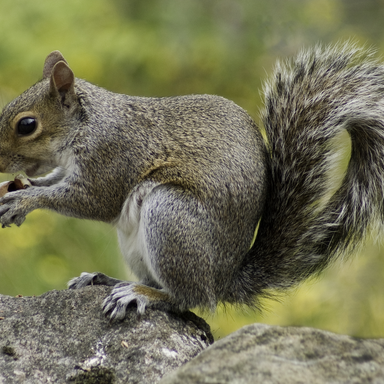

In [ ]:
custom_to_pil(preprocess_vqgan(image[0]))

Reconstructed

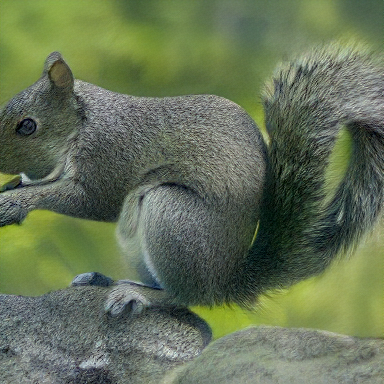

In [ ]:
custom_to_pil(preprocess_vqgan(np.asarray(rec[0])))